# Answering Business Questions using SQL

The guided project is about exploring the Chinook database and answer some of the hypothetical business questions using intermediate SQL skills.

### Connecting to Chinook Databse

Before starting to work on the questions, the Chinook database is connected to the Jupyter Kernel using the code written below.

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

#### Testing Functionalitites

We want to get ourselves familiarized with the schema of the database to perform various joins in the further steps.

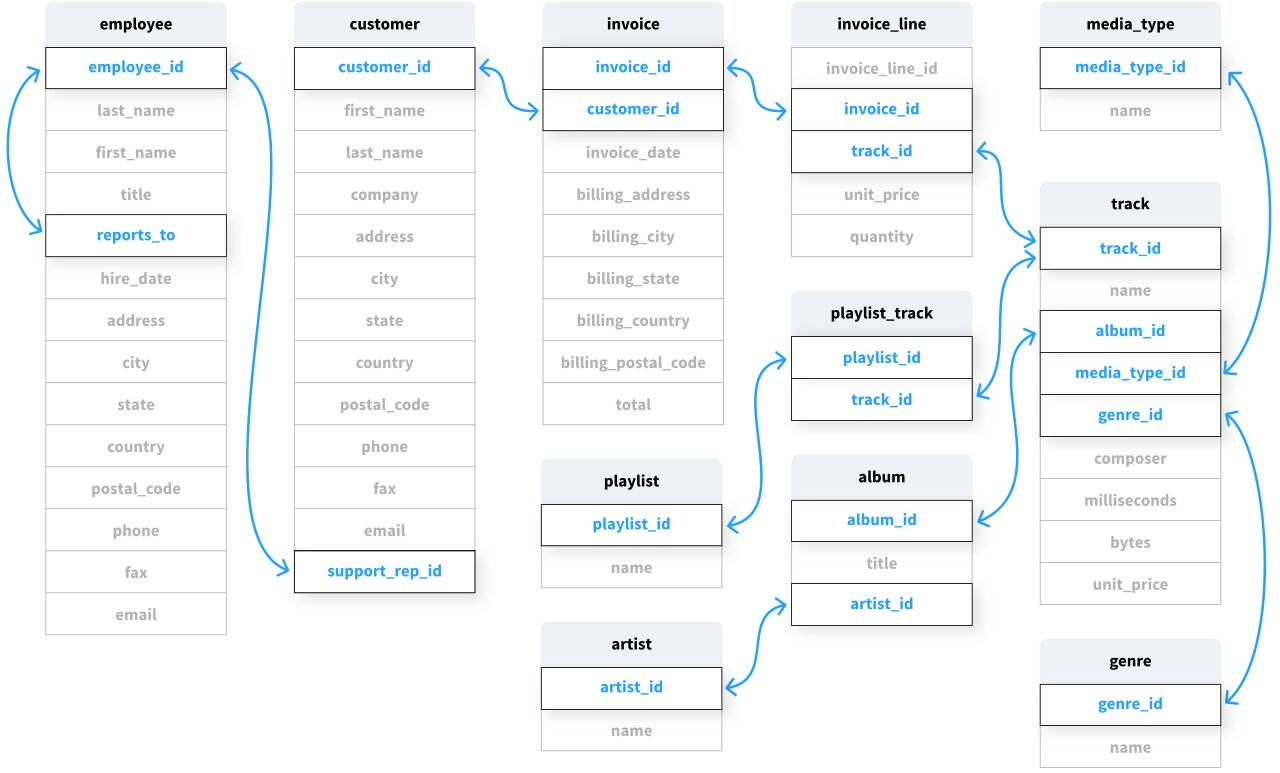

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Task One: Popular Music Genres in the USA

The Chinook record store has just signed a new deal, and the task is to select the top three popular albums from the list of four.

| Artist Name | Genre |
| :-: | :-: |
|Regal | Hip-Hop |
|Red Tone | Punk|
|Meteor and the Girls | Pop |
|Slim Jim Bites | Blues |

To achieve the task, I have pulled out the list of `tracks_sold` and `percentage_sold` grouped by `Genre`. The list is sorted in descending order and only top 3 entries are shown in the result. 

Using the **WITH** statement, CTE `usa_tracks_sold` is created to consider the data of the tracks that are sold only in the USA.

In [8]:
%%sql
with usa_tracks_sold as
    (
    SELECT il.*
    FROM invoice_line as il
    INNER JOIN invoice as i ON i.invoice_id = il.invoice_id
    INNER JOIN customer as c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    )
    
SELECT
    g.name as genre,
    COUNT(uts.invoice_line_id) as tracks_sold,
    ROUND(CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
                                                SELECT COUNT(*) FROM usa_tracks_sold)*100, 3) as percentage_sold
    FROM usa_tracks_sold as uts
    INNER JOIN track as t ON t.track_id = uts.track_id
    INNER JOIN genre as g ON g.genre_id = t.genre_id
    GROUP BY g.name
    ORDER BY 2 DESC;

 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage_sold
Rock,561,53.378
Alternative & Punk,130,12.369
Metal,124,11.798
R&B/Soul,53,5.043
Blues,36,3.425
Alternative,35,3.33
Pop,22,2.093
Latin,22,2.093
Hip Hop/Rap,20,1.903
Jazz,14,1.332


Looking at the results of the tracks sold in the USA based on the genre of the tracks, **Rock** tops the chart with 561 tracks sold covering more than 50% of the market followed by **Alternative & Punk** which covers approximately 12% of the market. Considering the options that Chinook record store has to choose from, **Blues** & **Pop** have better selling ratio than Hip-Hop.

### Conclusion of Task One

The Chinook record store should buy tracks of the following genres:

| Artist Name | Genre |
| :-: | :-: |
|Red Tone | Punk|
|Meteor and the Girls | Pop |
|Slim Jim Bites | Blues |

## Task Two: Chinook Employee Evaluation

In the second activity we have to analyze the perform of the sales rep to verify if any sales rep have more influence than others. 

To analyze the performance of the sales_rep, I have pulled out the `total_sales` of the respective `sales_rep` from their date of hiring.

In [16]:
%%sql

WITH customer_support_rep_sales AS
    (
    SELECT c.customer_id,
    c.support_rep_id,
    SUM(i.total) as total_sales
    FROM customer as c
    INNER JOIN invoice as i ON i.customer_id = c.customer_id
    GROUP BY 1, 2)
    
SELECT e.first_name || " " || e.last_name as employee_name,
    Date(e.hire_date) as hire_date,
    CAST(SUM(csp.total_sales) as INT) as total_sales
    FROM employee as e
    INNER JOIN customer_support_rep_sales as csp ON csp.support_rep_id = e.employee_id
    GROUP BY 1;

 * sqlite:///chinook.db
Done.


employee_name,hire_date,total_sales
Jane Peacock,2017-04-01,1731
Margaret Park,2017-05-03,1584
Steve Johnson,2017-10-17,1393


### Conclusion of Task Two

From the results of the querry, we can see that **Jane** has the highest amount of sales followed by **Margret** and **Steve** with the least. One conclusion which can be drawn is the hire_date of the employees, Jane was hired before Margaret and Steve, and so Jane has the highest sales compared to other two. 

## Task Three: Sales Performance by Country

For this activity, we want to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Grouping smaller markets as `Other` and forcing that row to the bottom of the results

In [19]:
%%sql
WITH country_or_other AS
(
SELECT 
    CASE 
        WHEN (
            SELECT COUNT(*)
            FROM customer
            where country = c.country) = 1 then 'Other'
        ELSE c.country
    END AS country,
    c.customer_id,
    il.*
    FROM invoice_line as il
    INNER JOIN invoice as i ON i.invoice_id = il.invoice_id
    INNER JOIN customer as c ON c.customer_id = i.customer_id
)

SELECT 
    country,
    customers,
    total_sales,
    average_order,
    avg_sales_per_customer
    
FROM 
(SELECT
     country,
    COUNT(DISTINCT(customer_id)) as customers,
    ROUND(SUM(unit_price), 2) as total_sales,
    ROUND(SUM(unit_price) / COUNT(DISTINCT(customer_id)), 2) as avg_sales_per_customer,
    ROUND(SUM(unit_price) / COUNT(DISTINCT(invoice_id)), 2) as average_order,
    CASE
     WHEN
         country = 'Other' THEN 1
     ELSE 0
     END as sort
FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC);
        

 * sqlite:///chinook.db
Done.


country,customers,total_sales,average_order,avg_sales_per_customer
USA,13,1040.49,7.94,80.04
Canada,8,535.59,7.05,66.95
Brazil,5,427.68,7.01,85.54
France,5,389.07,7.78,77.81
Germany,4,334.62,8.16,83.66
Czech Republic,2,273.24,9.11,136.62
United Kingdom,3,245.52,8.77,81.84
Portugal,2,185.13,6.38,92.57
India,2,183.15,8.72,91.58
Other,15,1094.94,7.45,73.0


**NOTE:**

The CTE `country_or_other` is created to tag the countries 'Other' which have only one customer by counting the customer data in invoice and invoice_line table.

## Task Four: Album vs Collection Purchases

In this last activity we have to identify the orders as either comprising of whole albums or collections made up of many individual tracks.

This is to drive the decision as to whether the Chinook store should move away from offering sales of full albums and only purchase and sell the most popular tracks for the sake of saving costs

To achieve the challenging task I decided to create a CTE which contains all the invoice_id and the minimum value of the `track_id` as the first_track_id for that invoice. The CTE will be used for creating two tables consisitng of all the track_ids to run the `EXCEPT` clause comparing the `Invoice_id` and `Album_id`.

In [28]:
%%sql

WITH invoice_first_track AS
(
SELECT il.invoice_id,
    MIN(il.track_id) as first_track_id
    FROM invoice_line as il
GROUP BY 1
)

SELECT Album_purchased,
    COUNT(invoice_id) as number_of_invoices,
    ROUND((CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice))*100) as percentage
    
    FROM 
        (
        SELECT ifs.*,
        CASE
           WHEN ( 
                SELECT t.track_id 
                    FROM track as t
                    where t.album_id = (
                                        SELECT t2.album_id
                                            FROM track as t2
                                            WHERE t2.track_id = ifs.first_track_id
                                        )
                EXCEPT

                SELECT il2.track_id
                    FROM invoice_line as il2
                    WHERE il2.invoice_id = ifs.invoice_id
               ) is null
            and
                (
                SELECT il2.track_id
                FROM invoice_line as il2
                WHERE il2.invoice_id = ifs.invoice_id

                EXCEPT
                    
                SELECT t.track_id 
                FROM track as t
                where t.album_id = (
                                    SELECT t2.album_id
                                        FROM track as t2
                                        WHERE t2.track_id = ifs.first_track_id
                                    )
                ) is null
            THEN 'YES'
            ELSE 'NO'
            END AS 'Album_purchased'
    FROM invoice_first_track as ifs
        )
    GROUP BY Album_purchased;
    

 * sqlite:///chinook.db
Done.


Album_purchased,number_of_invoices,percentage
NO,500,81.0
YES,114,19.0


### Conclusion of Task Four

The results of the above querry indicate that 81% of the orders comprise of the tracks purchased individually and 19% of the orders are purchased as a whole album. 


With 81% of the customers buying tracks individually, it is recommended to Chinook Store that they should buy the popular tracks from the albums instead of buying out entire album from the record companies. 